# tits
Technical Indicator Tests

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath
from pathlib import Path
from itertools import product
import logging
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname
    
def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fix_path(get_cwd('test.ipynb', 'recon' +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, vectorize
import talib as ta
import tulipy as ti
from dask import delayed

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns', 50)

from common_util import MUTATE_DIR, load_json, query_df, search_df, chained_filter, list_get_dict, is_empty_df, benchmark
from data.data_api import DataAPI
from mutate.common import get_graphs, get_transforms
#from mutate.fracdiff_util import *
#from mutate.runt_util import *
from mutate.runt import process_transform

DEBUG:matplotlib:$HOME=/home/kev
DEBUG:matplotlib:CONFIGDIR=/home/kev/.config/matplotlib
DEBUG:matplotlib:matplotlib data path: /home/kev/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/kev/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.1.1
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'impo

DEBUG:matplotlib:CACHEDIR=/home/kev/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/kev/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
CRITICAL:root:script location: /home/kev/crunch/recon/test.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


### Init API

In [2]:
DataAPI.__init__()
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
graphs, transforms = get_graphs(), get_transforms()

In [3]:
src_rcs, src_dfs = DataAPI.axe_load(['root', 'root_split'])

/home/kev/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kev/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kev/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kev/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [4]:
ex_df = src_dfs[['sp_500', 'root', 'root_split', 'join', 'trmi3']]
mkt = list(filter(lambda name: name.startswith('mkt'), ex_df.columns))
etf = list(filter(lambda name: name.startswith('etf'), ex_df.columns))

In [5]:
mkt

['mkt3_stockIndexBuzz_N',
 'mkt3_bondBuzz_N',
 'mkt3_ratesBuzz_N',
 'mkt3_stockIndexSentiment_N',
 'mkt3_stockIndexOptimism_N',
 'mkt3_stockIndexTrust_N',
 'mkt3_stockIndexFear_N',
 'mkt3_stockIndexStress_N',
 'mkt3_stockIndexSurprise_N',
 'mkt3_stockIndexUncertainty_N',
 'mkt3_stockIndexMarketRisk_N',
 'mkt3_stockIndexPriceDirection_N',
 'mkt3_stockIndexPriceForecast_N',
 'mkt3_stockIndexVolatility_N',
 'mkt3_bondSentiment_N',
 'mkt3_bondOptimism_N',
 'mkt3_bondTrust_N',
 'mkt3_bondFear_N',
 'mkt3_bondStress_N',
 'mkt3_bondSurprise_N',
 'mkt3_bondUncertainty_N',
 'mkt3_bondDefault_N',
 'mkt3_bondPriceDirection_N',
 'mkt3_bondPriceForecast_N',
 'mkt3_bondVolatility_N',
 'mkt3_centralBank_N',
 'mkt3_debtDefault_N',
 'mkt3_interestRates_N',
 'mkt3_interestRatesForecast_N',
 'mkt3_monetaryPolicyLooseVsTight_N',
 'mkt3_stockIndexBuzz_S',
 'mkt3_bondBuzz_S',
 'mkt3_ratesBuzz_S',
 'mkt3_stockIndexSentiment_S',
 'mkt3_stockIndexOptimism_S',
 'mkt3_stockIndexTrust_S',
 'mkt3_stockIndexFear_S',

In [6]:
etf

['etf3_buzz_N',
 'etf3_sentiment_N',
 'etf3_optimism_N',
 'etf3_joy_N',
 'etf3_loveHate_N',
 'etf3_trust_N',
 'etf3_anger_N',
 'etf3_conflict_N',
 'etf3_fear_N',
 'etf3_gloom_N',
 'etf3_stress_N',
 'etf3_surprise_N',
 'etf3_timeUrgency_N',
 'etf3_uncertainty_N',
 'etf3_violence_N',
 'etf3_emotionVsFact_N',
 'etf3_marketRisk_N',
 'etf3_longShort_N',
 'etf3_longShortForecast_N',
 'etf3_priceDirection_N',
 'etf3_priceForecast_N',
 'etf3_volatility_N',
 'etf3_analystRating_N',
 'etf3_debtDefault_N',
 'etf3_dividends_N',
 'etf3_innovation_N',
 'etf3_earningsForecast_N',
 'etf3_fundamentalStrength_N',
 'etf3_laborDispute_N',
 'etf3_layoffs_N',
 'etf3_litigation_N',
 'etf3_managementChange_N',
 'etf3_managementTrust_N',
 'etf3_mergers_N',
 'etf3_cyberCrime_N',
 'etf3_buzz_S',
 'etf3_sentiment_S',
 'etf3_optimism_S',
 'etf3_joy_S',
 'etf3_loveHate_S',
 'etf3_trust_S',
 'etf3_anger_S',
 'etf3_conflict_S',
 'etf3_fear_S',
 'etf3_gloom_S',
 'etf3_stress_S',
 'etf3_surprise_S',
 'etf3_timeUrgency_

### Load Data

In [8]:
res = list(process_transform(transforms['dohlca'], dump=False))

INFO:root:data: ['dow_jones', 'root', 'root_split_ohlca', 'join', 'pba']
DEBUG:root:rm_match: [['dow_jones', 'hrm', 'hrm', 'pba', 'pba']]
DEBUG:root:pre-runt:                            pba_open  pba_high   pba_low  pba_close  \
id                                                                   
1998-01-02 14:00:00+00:00   7910.24   7952.59   7910.24    7923.19   
1998-01-02 15:00:00+00:00   7923.19   7923.19   7880.85    7917.22   
1998-01-02 16:00:00+00:00   7917.22   7931.66   7914.48    7916.22   
1998-01-02 17:00:00+00:00   7915.72   7940.38   7915.72    7934.90   
1998-01-02 18:00:00+00:00   7934.65   7935.40   7916.22    7916.22   
...                             ...       ...       ...        ...   
2018-01-08 17:00:00+00:00  25259.27  25276.45  25253.96   25275.32   
2018-01-08 18:00:00+00:00  25275.07  25311.99  25275.07   25299.05   
2018-01-08 19:00:00+00:00  25298.96  25305.34  25289.86   25299.16   
2018-01-08 20:00:00+00:00  25299.39  25301.22  25265.93   25278.24   
2

/home/kev/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:456: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/home/kev/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:464: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


DEBUG:root:mutate_type: dohlca
DEBUG:root:post-runt:                            pba_open  pba_high   pba_low  pba_close  \
id                                                                   
2009-01-02 00:00:00+00:00   8771.77   9065.28   8761.10    9034.69   
2009-01-05 00:00:00+00:00   9027.13   9033.66   8892.68    8952.89   
2009-01-06 00:00:00+00:00   8954.57   9087.82   8941.11    9015.10   
2009-01-07 00:00:00+00:00   8996.94   8996.94   8720.00    8769.70   
2009-01-08 00:00:00+00:00   8769.94   8769.94   8651.27    8742.46   
...                             ...       ...       ...        ...   
2017-12-22 00:00:00+00:00  24764.04  24784.15  24717.51   24754.06   
2017-12-26 00:00:00+00:00  24715.84  24778.13  24708.42   24746.21   
2017-12-27 00:00:00+00:00  24766.52  24789.52  24731.68   24774.30   
2017-12-28 00:00:00+00:00  24807.21  24839.23  24797.13   24837.51   
2017-12-29 00:00:00+00:00  24849.63  24871.66  24719.22   24719.22   

                           pba_avgPr

INFO:root:data: ['dow_jones', 'root', 'root_split_ohlca', 'join', 'trmi3_mkt3_news_bondBuzz']
DEBUG:root:rm_match: [['dow_jones', 'hrm', 'hrm', 'trmi3', 'trmi3']]
DEBUG:root:pre-runt:                            mkt3_bondBuzz_N
id                                        
1998-01-02 14:00:00+00:00             59.0
1998-01-02 15:00:00+00:00             59.0
1998-01-02 16:00:00+00:00             59.0
1998-01-02 17:00:00+00:00             59.0
1998-01-02 18:00:00+00:00            333.0
...                                    ...
2018-01-08 17:00:00+00:00           1470.2
2018-01-08 18:00:00+00:00           1672.6
2018-01-08 19:00:00+00:00           1925.6
2018-01-08 20:00:00+00:00           2036.6
2018-01-08 21:00:00+00:00           2294.0

[39857 rows x 1 columns]
DEBUG:root:variant: ({'val': True, 'flt': 0}, {'val': True, 'flt': 'h'}, {'val': True, 'flt': 'l'}, {'val': True, 'flt': -1}, {'stat_type': 'avg'})
DEBUG:root:subvar: {'val': True, 'flt': 0}
DEBUG:root:subvar: {'val': True, 'flt': 

DEBUG:root:variant: ({'val': True, 'flt': 0}, {'val': True, 'flt': 'h'}, {'val': True, 'flt': 'l'}, {'val': True, 'flt': -1}, {'stat_type': 'avg'})
DEBUG:root:subvar: {'val': True, 'flt': 0}
DEBUG:root:subvar: {'val': True, 'flt': 'h'}
DEBUG:root:subvar: {'val': True, 'flt': 'l'}
DEBUG:root:subvar: {'val': True, 'flt': -1}
DEBUG:root:subvar: {'stat_type': 'avg'}
DEBUG:root:mutate_type: dohlca
DEBUG:root:post-runt:                            mkt3_stockIndexBuzz_N_open  \
id                                                      
2009-01-02 00:00:00+00:00                 2868.400000   
2009-01-05 00:00:00+00:00                 4000.700000   
2009-01-06 00:00:00+00:00                 8320.600000   
2009-01-07 00:00:00+00:00                 7012.200000   
2009-01-08 00:00:00+00:00                10050.300000   
...                                               ...   
2017-12-22 00:00:00+00:00                 9263.800000   
2017-12-26 00:00:00+00:00                 1039.800000   
2017-12-27 0

DEBUG:root:variant: ({'val': True, 'flt': 0}, {'val': True, 'flt': 'h'}, {'val': True, 'flt': 'l'}, {'val': True, 'flt': -1}, {'stat_type': 'avg'})
DEBUG:root:subvar: {'val': True, 'flt': 0}
DEBUG:root:subvar: {'val': True, 'flt': 'h'}
DEBUG:root:subvar: {'val': True, 'flt': 'l'}
DEBUG:root:subvar: {'val': True, 'flt': -1}
DEBUG:root:subvar: {'stat_type': 'avg'}
DEBUG:root:mutate_type: dohlca
DEBUG:root:post-runt:                            mkt3_ratesBuzz_S_open  mkt3_ratesBuzz_S_high  \
id                                                                        
2009-01-02 00:00:00+00:00                  225.5                  283.0   
2009-01-05 00:00:00+00:00                  393.5                  535.0   
2009-01-06 00:00:00+00:00                  479.0                  549.5   
2009-01-07 00:00:00+00:00                  697.0                  697.0   
2009-01-08 00:00:00+00:00                  358.5                  474.0   
...                                          ...         

DEBUG:root:rm_match: [['dow_jones', 'hrm', 'hrm', 'vol', 'vol']]
DEBUG:root:pre-runt:                            vol_open  vol_high  vol_low  vol_close  \
id                                                                  
2005-03-18 14:00:00+00:00     12.02     12.06    11.89      11.91   
2005-03-18 15:00:00+00:00     11.95     12.22    11.86      12.17   
2005-03-18 16:00:00+00:00     12.18     12.21    11.81      11.85   
2005-03-18 17:00:00+00:00     11.85     12.02    11.84      11.95   
2005-03-18 18:00:00+00:00     11.95     12.41    11.94      12.08   
...                             ...       ...      ...        ...   
2018-01-08 17:00:00+00:00     10.59     10.62    10.47      10.48   
2018-01-08 18:00:00+00:00     10.48     10.50    10.18      10.40   
2018-01-08 19:00:00+00:00     10.40     10.42    10.20      10.40   
2018-01-08 20:00:00+00:00     10.44     10.56    10.29      10.45   
2018-01-08 21:00:00+00:00     10.45     10.53     9.89      10.52   

                

INFO:root:data: ['nasdaq_100', 'root', 'root_split_ohlca', 'join', 'trmi3_etf3_social_buzz']
DEBUG:root:rm_match: [['nasdaq_100', 'hrm', 'hrm', 'trmi3', 'trmi3']]
DEBUG:root:pre-runt:                             etf3_buzz_S
id                                     
1998-01-02 14:00:00+00:00   3675.400000
1998-01-02 15:00:00+00:00   3776.200000
1998-01-02 16:00:00+00:00   3943.700000
1998-01-02 17:00:00+00:00   4006.500000
1998-01-02 18:00:00+00:00   4124.600000
...                                 ...
2018-01-08 17:00:00+00:00  26123.100001
2018-01-08 18:00:00+00:00  28744.100002
2018-01-08 19:00:00+00:00  30492.000002
2018-01-08 20:00:00+00:00  32660.500002
2018-01-08 21:00:00+00:00  34713.600002

[39417 rows x 1 columns]
DEBUG:root:variant: ({'val': True, 'flt': 0}, {'val': True, 'flt': 'h'}, {'val': True, 'flt': 'l'}, {'val': True, 'flt': -1}, {'stat_type': 'avg'})
DEBUG:root:subvar: {'val': True, 'flt': 0}
DEBUG:root:subvar: {'val': True, 'flt': 'h'}
DEBUG:root:subvar: {'val': True, '

DEBUG:root:subvar: {'val': True, 'flt': 0}
DEBUG:root:subvar: {'val': True, 'flt': 'h'}
DEBUG:root:subvar: {'val': True, 'flt': 'l'}
DEBUG:root:subvar: {'val': True, 'flt': -1}
DEBUG:root:subvar: {'stat_type': 'avg'}
DEBUG:root:mutate_type: dohlca
DEBUG:root:post-runt:                            mkt3_ratesBuzz_N_open  mkt3_ratesBuzz_N_high  \
id                                                                        
2009-01-02 00:00:00+00:00                  753.5                 1289.0   
2009-01-05 00:00:00+00:00                 1831.0                 2907.5   
2009-01-06 00:00:00+00:00                 2873.5                 2873.5   
2009-01-07 00:00:00+00:00                 4068.5                 4304.5   
2009-01-08 00:00:00+00:00                 3376.5                 3400.5   
...                                          ...                    ...   
2017-12-22 00:00:00+00:00                 1496.5                 1497.0   
2017-12-26 00:00:00+00:00                  457.5       

DEBUG:root:variant: ({'val': True, 'flt': 0}, {'val': True, 'flt': 'h'}, {'val': True, 'flt': 'l'}, {'val': True, 'flt': -1}, {'stat_type': 'avg'})
DEBUG:root:subvar: {'val': True, 'flt': 0}
DEBUG:root:subvar: {'val': True, 'flt': 'h'}
DEBUG:root:subvar: {'val': True, 'flt': 'l'}
DEBUG:root:subvar: {'val': True, 'flt': -1}
DEBUG:root:subvar: {'stat_type': 'avg'}


KeyboardInterrupt: 

In [ ]:
idx=0
print(res[idx][0])
src_df = res[idx][1]

In [ ]:
src_df.values

In [ ]:
try:
    ema = ti.ema(src_df.iloc[:, 0].values, period=3)
except ti.InvalidOptionError:
    print("Invalid Option!")

In [ ]:
ema

In [ ]:
print (ta.get_function_groups())
#print(ta.get_functions())

### Load Data

In [6]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

search_terms = {
    'stage': 'raw',
    'raw_cat': 'us_equity_index'
}
date_range = {
    'id': ('lt', 2018)
}
dfs = {}
with benchmark('data load') as b:
    for rec, df in DataAPI.generate(search_terms):
        dfs[rec.name] = df.loc[search_df(df, date_range)]

print(', '.join(dfs.keys()))

/home/kev/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:698: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/kev/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:725: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/kev/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:742: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels
/home/kev/miniconda3/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/home/kev/miniconda3/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning: The defau

dow_jones_raw_0, sp_500_raw_1, nasdaq_100_raw_2, russell_2000_raw_3


## Test Fracdiff runt transform

In [4]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [5]:
from mutate.fracdiff import *

def get_desc_pfx(kc, base_rec):
	"""
	Crude workaround...
	"""
	if (base_rec.stage=='raw' and base_rec.desc=='raw'):
		return kc[-1]
	elif (base_rec.stage=='mutate' and base_rec.desc=='fth thresh' and base_rec.mutate_type=='thresh'):
		return kc[-1]
	else:
		return base_rec.desc
    
def make_runt_entry(desc, mutate_freq, mutate_type, base_rec):
	prev_hist = '' if isinstance(base_rec.hist, float) else str(base_rec.hist)

	return {
		'freq': mutate_freq,
		'root': base_rec.root,
		'basis': base_rec.name,
		'stage': 'mutate',
		'mutate_type': mutate_type,
		'raw_cat': base_rec.raw_cat,
		'hist': '->'.join([prev_hist, str('mutate_' +mutate_type)]),
		'desc': desc
	}

In [6]:
date_range = {
    'id': ('gt', 2009)
}

In [38]:
dr = ['sym', 'sym']
dr_dg, dr_cs = list_get_dict(dg, dr), list_get_dict(cs2, dr)
dr_paths, dr_recs, dr_dfs = DataAPI.load_from_dg(dr_dg, dr_cs)

In [39]:
dr_dfs['dow_jones']

defaultdict(<function common_util.recursive_dict()>,
            {'dzn_gau': defaultdict(<function common_util.recursive_dict()>,
                         {'raw_pba': defaultdict(<function common_util.recursive_dict()>,
                                      {'raw_pba_dzn_gau(2)':                           pba_open pba_high pba_low pba_close pba_avgPrice
                                       id                                                                        
                                       1998-01-02 14:00:00+00:00        1        2       1         1            2
                                       1998-01-02 15:00:00+00:00        2        1       1         1            1
                                       1998-01-02 16:00:00+00:00        1        1       2         1            1
                                       1998-01-02 17:00:00+00:00        1        1       2         2            2
                                       1998-01-02 18:00:00+00:00        2 

In [19]:
trfs_dir = MUTATE_DIR +default_runt_dir_name +default_trfs_dir_name
runt_trfs = 'drffd.json'
step_info = load_json(runt_trfs, dir_path=trfs_dir)

In [10]:
meta, fn, var, rm, src, dst = step_info['meta'], step_info['fn'], step_info['var'], step_info['rm'], step_info['src'], step_info['dst']

# Loading transform, apply, and frequency settings
ser_fn = RUNT_FN_TRANSLATOR[fn['ser_fn']]
rtype_fn = RUNT_TYPE_TRANSLATOR[fn['df_fn']]
col_fn = RUNT_NMAP_TRANSLATOR[fn['col_fn']]
freq = RUNT_FREQ_TRANSLATOR[fn['freq']]
res_freq = RUNT_FREQ_TRANSLATOR[meta['res_freq']]

In [11]:
var = {
    #"d": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0],
    "d": [0.5],
    "size": [None],
    #"thresh": [1e-4, 1e-3, 1e-2, 1e-1],
    "thresh": [1e-5]
}
if (meta['var_fmt'] == 'grid'):
    var_names, param_combos = list(var.keys()), list(product(*var.values()))
    variants = [{var_names[idx]: param_value for idx, param_value in enumerate(combo)} for combo in param_combos]

In [12]:
for key_chain in dr_paths:
    src_rec, src_df = list_get_dict(dr_recs, key_chain), list_get_dict(dr_dfs, key_chain)
    src_df = src_df.loc[search_df(src_df, date_range), :].dropna(axis=0, how='all')
        
    for variant in variants:
        runted_df = rtype_fn(src_df, ser_fn(**variant), freq, col_fn(**variant))
        desc_sfx = meta['rec_fmt'].format(**variant)
        desc_pfx = get_desc_pfx(key_chain, src_rec)
        desc = '_'.join([desc_pfx, desc_sfx])

        if (meta['mtype_from']=='name'):       mutate_type = meta['name']
        elif (meta['mtype_from']=='rec_fmt'):  mutate_type = desc_sfx

        assert(not is_empty_df(runted_df))
        entry = make_runt_entry(desc, res_freq, mutate_type, src_rec)
        logging.info('dumping ' +desc +'...')
        logging.debug('post_transform: ' +str(runted_df))
    break

DEBUG:root:weights: [[-1.00150824e-05 -1.00313318e-05 -1.00476253e-05 -1.00639629e-05
  -1.00803448e-05 -1.00967712e-05 -1.01132423e-05 -1.01297582e-05
  -1.01463191e-05 -1.01629252e-05 -1.01795767e-05 -1.01962736e-05
  -1.02130163e-05 -1.02298048e-05 -1.02466394e-05 -1.02635201e-05
  -1.02804473e-05 -1.02974211e-05 -1.03144416e-05 -1.03315091e-05
  -1.03486237e-05 -1.03657856e-05 -1.03829950e-05 -1.04002520e-05
  -1.04175569e-05 -1.04349099e-05 -1.04523111e-05 -1.04697607e-05
  -1.04872589e-05 -1.05048059e-05 -1.05224019e-05 -1.05400471e-05
  -1.05577416e-05 -1.05754857e-05 -1.05932796e-05 -1.06111234e-05
  -1.06290173e-05 -1.06469617e-05 -1.06649565e-05 -1.06830021e-05
  -1.07010987e-05 -1.07192464e-05 -1.07374455e-05 -1.07556961e-05
  -1.07739985e-05 -1.07923528e-05 -1.08107593e-05 -1.08292182e-05
  -1.08477297e-05 -1.08662940e-05 -1.08849113e-05 -1.09035818e-05
  -1.09223057e-05 -1.09410833e-05 -1.09599148e-05 -1.09788004e-05
  -1.09977402e-05 -1.10167346e-05 -1.10357837e-05 -1.105

INFO:root:dumping raw_pba_drf_drffd(0.5000,0.0000)...
DEBUG:root:post_transform:                               pba_open    pba_close  pba_avgPrice
id                                                               
2012-09-04 00:00:00+00:00   343.251762   277.692884    278.196713
2012-09-05 00:00:00+00:00   255.259612   266.810146    262.315880
2012-09-06 00:00:00+00:00   287.892954   443.976892    428.517631
2012-09-07 00:00:00+00:00   532.933422   463.669940    471.944113
2012-09-10 00:00:00+00:00   431.272386   385.594342    381.006156
2012-09-11 00:00:00+00:00   338.241736   406.147792    386.445177
2012-09-12 00:00:00+00:00   415.318368   404.600112    428.802490
2012-09-13 00:00:00+00:00   386.362531   367.709305    362.270719
2012-09-14 00:00:00+00:00   580.615723   626.070314    622.773030
2012-09-17 00:00:00+00:00   515.010086   464.267635    467.028349
2012-09-18 00:00:00+00:00   422.491093   409.854340    398.861693
2012-09-19 00:00:00+00:00   429.821912   431.762286    439.22

/home/kev/crunch/mutate/runt_util.py:179: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  return lambda ser: ser.dropna().rolling(window=len(weights), min_periods=len(weights)).apply(dot_weights_fn)


DEBUG:root:weights: [[1]]
DEBUG:root:finished computing weights: [[1]]
DEBUG:root:weights: [[-0.0110937  -0.01316201 -0.01611675 -0.0206625  -0.0285     -0.045
  -0.1         1.        ]]
DEBUG:root:finished computing weights: [[ 1.     -0.1    -0.045  -0.0285]]
DEBUG:root:weights: [[-0.01097303 -0.01246935 -0.01438771 -0.01692672 -0.0204288  -0.025536
  -0.0336     -0.048      -0.08       -0.2         1.        ]]
DEBUG:root:finished computing weights: [[ 1.    -0.2   -0.08  -0.048]]
DEBUG:root:weights: [[-0.01042095 -0.01181757 -0.01358341 -0.01587672 -0.01895727 -0.02328086
  -0.02972025 -0.0401625  -0.0595     -0.105      -0.3         1.        ]]
DEBUG:root:finished computing weights: [[ 1.     -0.3    -0.105  -0.0595]]
DEBUG:root:weights: [[-0.01100641 -0.01279816 -0.01515571 -0.01837056 -0.0229632  -0.029952
  -0.0416     -0.064      -0.12       -0.4         1.        ]]
DEBUG:root:finished computing weights: [[ 1.    -0.4   -0.12  -0.064]]
DEBUG:root:weights: [[-0.01091003 -0.0

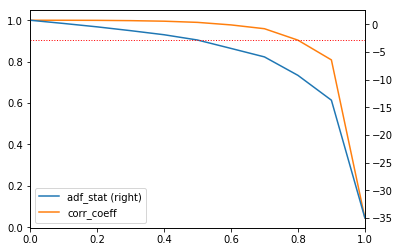

In [12]:
tbl = plot_min_FFD_ser(src_df[['pba_close']], 'pba_close', thresh=1e-2)

In [13]:
tbl

,adf_stat,p_val,lags,n_obs,95%_conf,corr_coeff
0.0,0.758602,9.909377e-01,1.0,2264.0,-2.862817,1.000000
0.1,0.178048,9.710032e-01,1.0,2257.0,-2.862821,0.999935
0.2,-0.435106,9.040703e-01,1.0,2254.0,-2.862823,0.999473
0.3,-1.123271,7.057031e-01,1.0,2253.0,-2.862824,0.998099
0.4,-1.860462,3.508832e-01,1.0,2254.0,-2.862823,0.995410
0.5,-2.816629,5.593747e-02,1.0,2255.0,-2.862823,0.989739
0.6,-4.334350,3.871516e-04,1.0,2256.0,-2.862822,0.977472
0.7,-5.870221,3.253438e-07,1.0,2258.0,-2.862821,0.959105
0.8,-9.205855,1.945884e-15,1.0,2259.0,-2.862820,0.903891
0.9,-13.699386,1.298371e-25,1.0,2261.0,-2.862819,0.808412


In [13]:
tbl2 = grid_fracdiff_pd(src_df, num=10, thresh=1e-2)

DEBUG:root:weights: [[1]]
DEBUG:root:finished computing weights: [[1]]
DEBUG:root:weights: [[-0.0110937  -0.01316201 -0.01611675 -0.0206625  -0.0285     -0.045
  -0.1         1.        ]]
DEBUG:root:finished computing weights: [[ 1.     -0.1    -0.045  -0.0285]]
DEBUG:root:weights: [[-0.01097303 -0.01246935 -0.01438771 -0.01692672 -0.0204288  -0.025536
  -0.0336     -0.048      -0.08       -0.2         1.        ]]
DEBUG:root:finished computing weights: [[ 1.    -0.2   -0.08  -0.048]]
DEBUG:root:weights: [[-0.01042095 -0.01181757 -0.01358341 -0.01587672 -0.01895727 -0.02328086
  -0.02972025 -0.0401625  -0.0595     -0.105      -0.3         1.        ]]
DEBUG:root:finished computing weights: [[ 1.     -0.3    -0.105  -0.0595]]
DEBUG:root:weights: [[-0.01100641 -0.01279816 -0.01515571 -0.01837056 -0.0229632  -0.029952
  -0.0416     -0.064      -0.12       -0.4         1.        ]]
DEBUG:root:finished computing weights: [[ 1.    -0.4   -0.12  -0.064]]
DEBUG:root:weights: [[-0.01091003 -0.0

In [15]:
tbl2

,,adf_stat,p_val,lags,n_obs,95%_conf,corr_coeff
name,d,,,,,,
pba_avgPrice,0.0,0.766098,0.991069,1.0,2264.0,-2.86282,1
pba_close,0.0,0.758602,0.990938,1.0,2264.0,-2.86282,1
pba_open,0.0,0.806224,0.991736,1.0,2264.0,-2.86282,1
pba_avgPrice,0.1,0.197607,0.972127,1.0,2257.0,-2.86282,0.999938
pba_close,0.1,0.178048,0.971003,1.0,2257.0,-2.86282,0.999935
pba_open,0.1,0.245659,0.974709,1.0,2257.0,-2.86282,0.999933
pba_avgPrice,0.2,-0.384274,0.912691,1.0,2254.0,-2.86282,0.999497
pba_close,0.2,-0.435106,0.90407,1.0,2254.0,-2.86282,0.999473
pba_open,0.2,-0.375168,0.914163,1.0,2254.0,-2.86282,0.999457


In [18]:
src_df

,pba_open,pba_close,pba_avgPrice
id,,,
2009-01-02 00:00:00+00:00,8771.77,8783.08,8795.6230
2009-01-05 00:00:00+00:00,9027.13,8924.38,8948.5753
2009-01-06 00:00:00+00:00,8954.57,9063.76,9038.0597
2009-01-07 00:00:00+00:00,8996.94,8892.52,8884.4652
2009-01-08 00:00:00+00:00,8769.94,8668.07,8691.6475
2009-01-09 00:00:00+00:00,8738.80,8626.66,8676.5253
2009-01-12 00:00:00+00:00,8599.26,8563.57,8560.4045
2009-01-13 00:00:00+00:00,8474.61,8495.48,8480.1094
2009-01-14 00:00:00+00:00,8446.01,8268.88,8285.7010
